In [ ]:
#### Setup ####
# install and import required packages
!pip install scanpy
import torch; torch.manual_seed(100)
import torch.nn as nn
import torch.utils
import torch.distributions
import torchvision
from torchvision import datasets, transforms
import math
import numpy as np
np.random.seed(100)
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import scanpy as sc
from collections import OrderedDict
from collections import Counter

# select the right device, depending on whether your Colab runs on GPU or CPU
### IMPORTANT: we recommend to change your runtime to GPU, otherwise the training takes much longer
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


cuda


## Interpretable variational autoencoders for the analysis of scRNA-Seq data
### Objective

In this practical session, you will learn how variational autoencoders (VAEs) can be modified to be biologically interpretable and how these models can be used to analyze **biological processes**. <br>
We will first build a "standard" VAE, which provides a low dimensional representation of the data set with a clear clustering into conditions and cell types, but whose features are **not directly interpretable**. <br>

Then, we will modify this VAE, so that its latent variables can be directly interpreted as **biological processes**. Therefore, we will follow the same principle that is applied in **VEGA**, proposed by [Seninge *et al* (2021)](https://www.nature.com/articles/s41467-021-26017-0) (more about this later). We will use this model to compare pathway activities between cell types and treatment conditions. <br>

### Data set
For the analysis, we will use a data set that contains peripheral blood mononuclear cells (PBMCs) from systemic lupus patients, treated with Interferon beta or untreated (control). The data set is already preprocessed and is stored as an **AnnData** object. You can read more about this data format [here](https://anndata.readthedocs.io/en/latest/tutorials/notebooks/getting-started.html).<br>

An AnnData object contains the gene expression data in its `.X` attribute, stored as a sparse matrix. Annotations for the observations (cells) are stored in the `.obs` attribute, and annotations for the variables (genes) in the `.var` attribute. We can select specific features of the `.obs` or `.var` attribute using squared brackets, e.g. `PBMC_train.obs["cell_type"]` :

In [ ]:
# download the data
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zHJKoU8QcQB4cLR-oICO2YY4Nu-QaZHG' -O PBMC_train.h5ad
# load data as anndata object
PBMC_train = sc.read_h5ad("PBMC_train.h5ad")

--2024-03-28 12:42:02--  https://docs.google.com/uc?export=download&id=1zHJKoU8QcQB4cLR-oICO2YY4Nu-QaZHG
Resolving docs.google.com (docs.google.com)... 142.251.180.113, 142.251.180.102, 142.251.180.101, ...
Connecting to docs.google.com (docs.google.com)|142.251.180.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1zHJKoU8QcQB4cLR-oICO2YY4Nu-QaZHG&export=download [following]
--2024-03-28 12:42:02--  https://drive.usercontent.google.com/download?id=1zHJKoU8QcQB4cLR-oICO2YY4Nu-QaZHG&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.112.132, 2607:f8b0:4001:c5f::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.112.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45277554 (43M) [application/octet-stream]
Saving to: ‘PBMC_train.h5ad’

PBMC_train.h5ad     100%[===================>]  43.18M   110MB

Let's take a closer look at the data:

In [ ]:
print(PBMC_train) #the data is stored as an anndata object
print(Counter(PBMC_train.obs["cell_type"])) #summary of cell types
print(Counter(PBMC_train.obs["condition"])) #summary of conditions

AnnData object with n_obs × n_vars = 13515 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'
Counter({'CD4T': 4452, 'FCGR3A+Mono': 2881, 'CD14+Mono': 2049, 'B': 1448, 'NK': 931, 'CD8T': 892, 'Dendritic': 862})
Counter({'stimulated': 7109, 'control': 6406})


## Standard VAE

We will first build a "standard" VAE. The code for this is not explained in detail, since this should be already familiar from previous sessions. <br>

We define the `Encoder` as a two-layer, non-linear and fully connected neural network. The latent space is sampled from a multivariate normal distribution. We further use dropout layers in the encoder/latent space:


In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dims, input_dims, dropout, z_dropout): #dropout, z_dropout define the dropout rates of the encoder/latent space
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dims, 800),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout),
                                     nn.Linear(800, 800),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout))  #two layer, fully connected encoder with dropout


        self.mu = nn.Sequential(nn.Linear(800, latent_dims),
                                nn.Dropout(p = z_dropout))

        self.sigma = nn.Sequential(nn.Linear(800, latent_dims),
                                   nn.Dropout(p = z_dropout))

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
        self.kl = 0

    def forward(self, x):
        x = self.encoder(x)
        mu =  self.mu(x)
        sigma = torch.exp(self.mu(x)) # exp for numeric stability
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (0.5*sigma**2 + 0.5*mu**2 - torch.log(sigma) - 1/2).sum() #calculation of kullback-leibler divergence

        return z


We further define the `Decoder` as two-layer, non linear and fully connected neural network:

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dims, input_dims, dropout):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(nn.Linear(latent_dims, 800),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout),
                                     nn.Linear(800, input_dims)
                                     )

    def forward(self, z):
        z = self.decoder(z)
        return z

The class `VariationalAutoencoder` combines the Encoder and Decoder:

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims, input_dims,dropout = 0.3, z_dropout=0.3):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dims, input_dims, dropout, z_dropout)
        self.decoder = Decoder(latent_dims, input_dims, dropout)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In order to train the model, we use the following training function, which returns the trained model and a list of the losses after each epoch. Beta defines the weight of the KLD.

In [ ]:
def train(vae, data, epochs=50, beta = 0.001, learning_rate = 0.0001):
    opt = torch.optim.Adam(vae.parameters(), lr = learning_rate) # ADAM optimizer
    losses = []
    klds = []
    mses = []
    vae.train() #train mode (then, dropout layers are considered)

    for epoch in range(epochs):
        loss_e = 0
        kld_e = 0
        mse_e = 0

        for x in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = vae(x)
            mse = ((x - x_hat)**2).sum()
            kld = beta* vae.encoder.kl
            loss = mse +  kld # loss calculation
            loss.backward()
            opt.step()
            loss_e += loss.to('cpu').detach().numpy()
            kld_e += kld.to('cpu').detach().numpy()
            mse_e += mse.to('cpu').detach().numpy()

        losses.append(loss_e/(len(data)*128))
        klds.append(kld_e/(len(data)*128))
        mses.append(mse_e/(len(data)*128))

        print("epoch: ", epoch, " loss: ", loss_e/(len(data)*128))

    return vae, losses, klds, mses

In [ ]:
PBMC_trainX = torch.utils.data.DataLoader(PBMC_train.X.A, batch_size=128) #set up the training data in the right format
latent_dims = 50 #choose the number of latent variables

We can now initialize our VAE and use the PBMC data to train the model:

In [ ]:
vae = VariationalAutoencoder(latent_dims = latent_dims, input_dims = PBMC_train.shape[1]).to(device)
vae, losses, klds, mses = train(vae, PBMC_trainX, beta = 0.001) # takes about 1 min on GPU

epoch:  0  loss:  513.536498591585
epoch:  1  loss:  351.178267712863
epoch:  2  loss:  305.13110049265737
epoch:  3  loss:  278.5065679010355
epoch:  4  loss:  258.0582905895305
epoch:  5  loss:  241.07480923634654
epoch:  6  loss:  226.31014431647534
epoch:  7  loss:  216.009990404237
epoch:  8  loss:  208.95971017513634
epoch:  9  loss:  204.8208218700481
epoch:  10  loss:  200.99840682407594
epoch:  11  loss:  197.2385293492731
epoch:  12  loss:  193.88886793604436
epoch:  13  loss:  191.31420430597268
epoch:  14  loss:  190.22944007729583
epoch:  15  loss:  189.4800892955852
epoch:  16  loss:  187.6732131670106
epoch:  17  loss:  186.64440831598245
epoch:  18  loss:  186.33485772474756
epoch:  19  loss:  184.78939711372809
epoch:  20  loss:  184.66170264190097
epoch:  21  loss:  184.67536220910415
epoch:  22  loss:  184.0615051557433
epoch:  23  loss:  182.80410162008033
epoch:  24  loss:  182.2869801071455
epoch:  25  loss:  181.94199738412533
epoch:  26  loss:  181.2986073763865

We can plot the loss curve and see that it converges well:

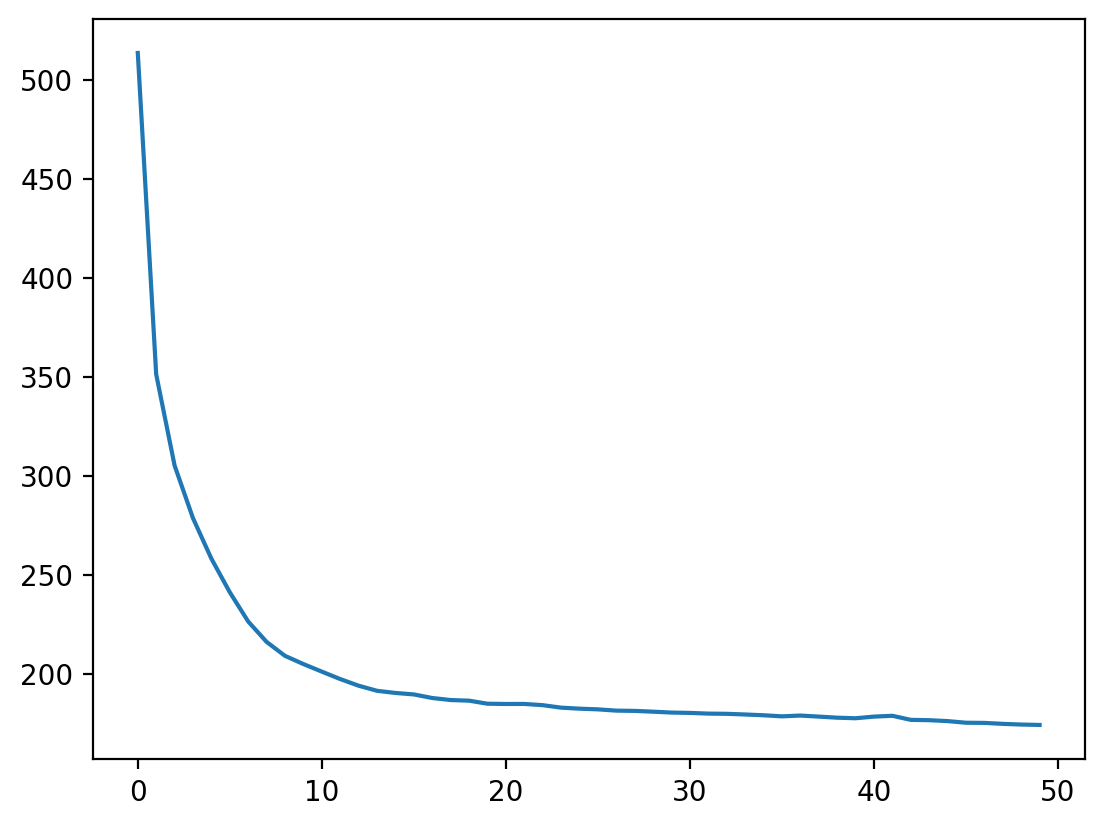

In [ ]:
plt.plot(losses)

We can further look at the MSE and the KLD:

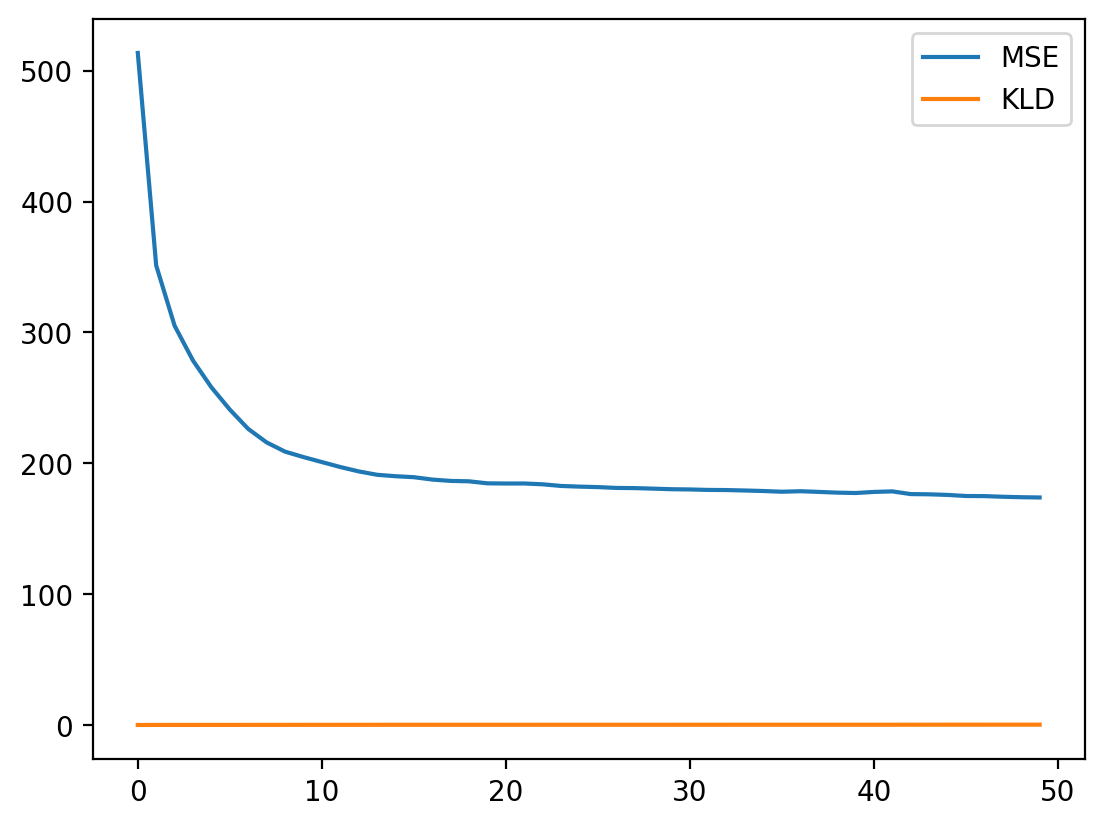

In [ ]:
plt.plot(mses, label = "MSE")
plt.plot(klds, label = "KLD")
plt.legend()

We can project the data to the latent space, and store this in the anndata object:

In [ ]:
def to_latent(vae, adata):
        latent = []
        data = torch.tensor(adata.X.A).to(device)
        vae.eval() # we need to set the model to evaluation mode, so that the dropout is no longer considered
        z = vae.encoder(data)
        latent += [z.to("cpu")]
        return torch.cat(latent).detach().numpy()

In [ ]:
PBMC_train.obsm["latent_embedding"] = to_latent(vae, PBMC_train)

We can further visualize the embedding of the cells in the latent space using UMAP:  

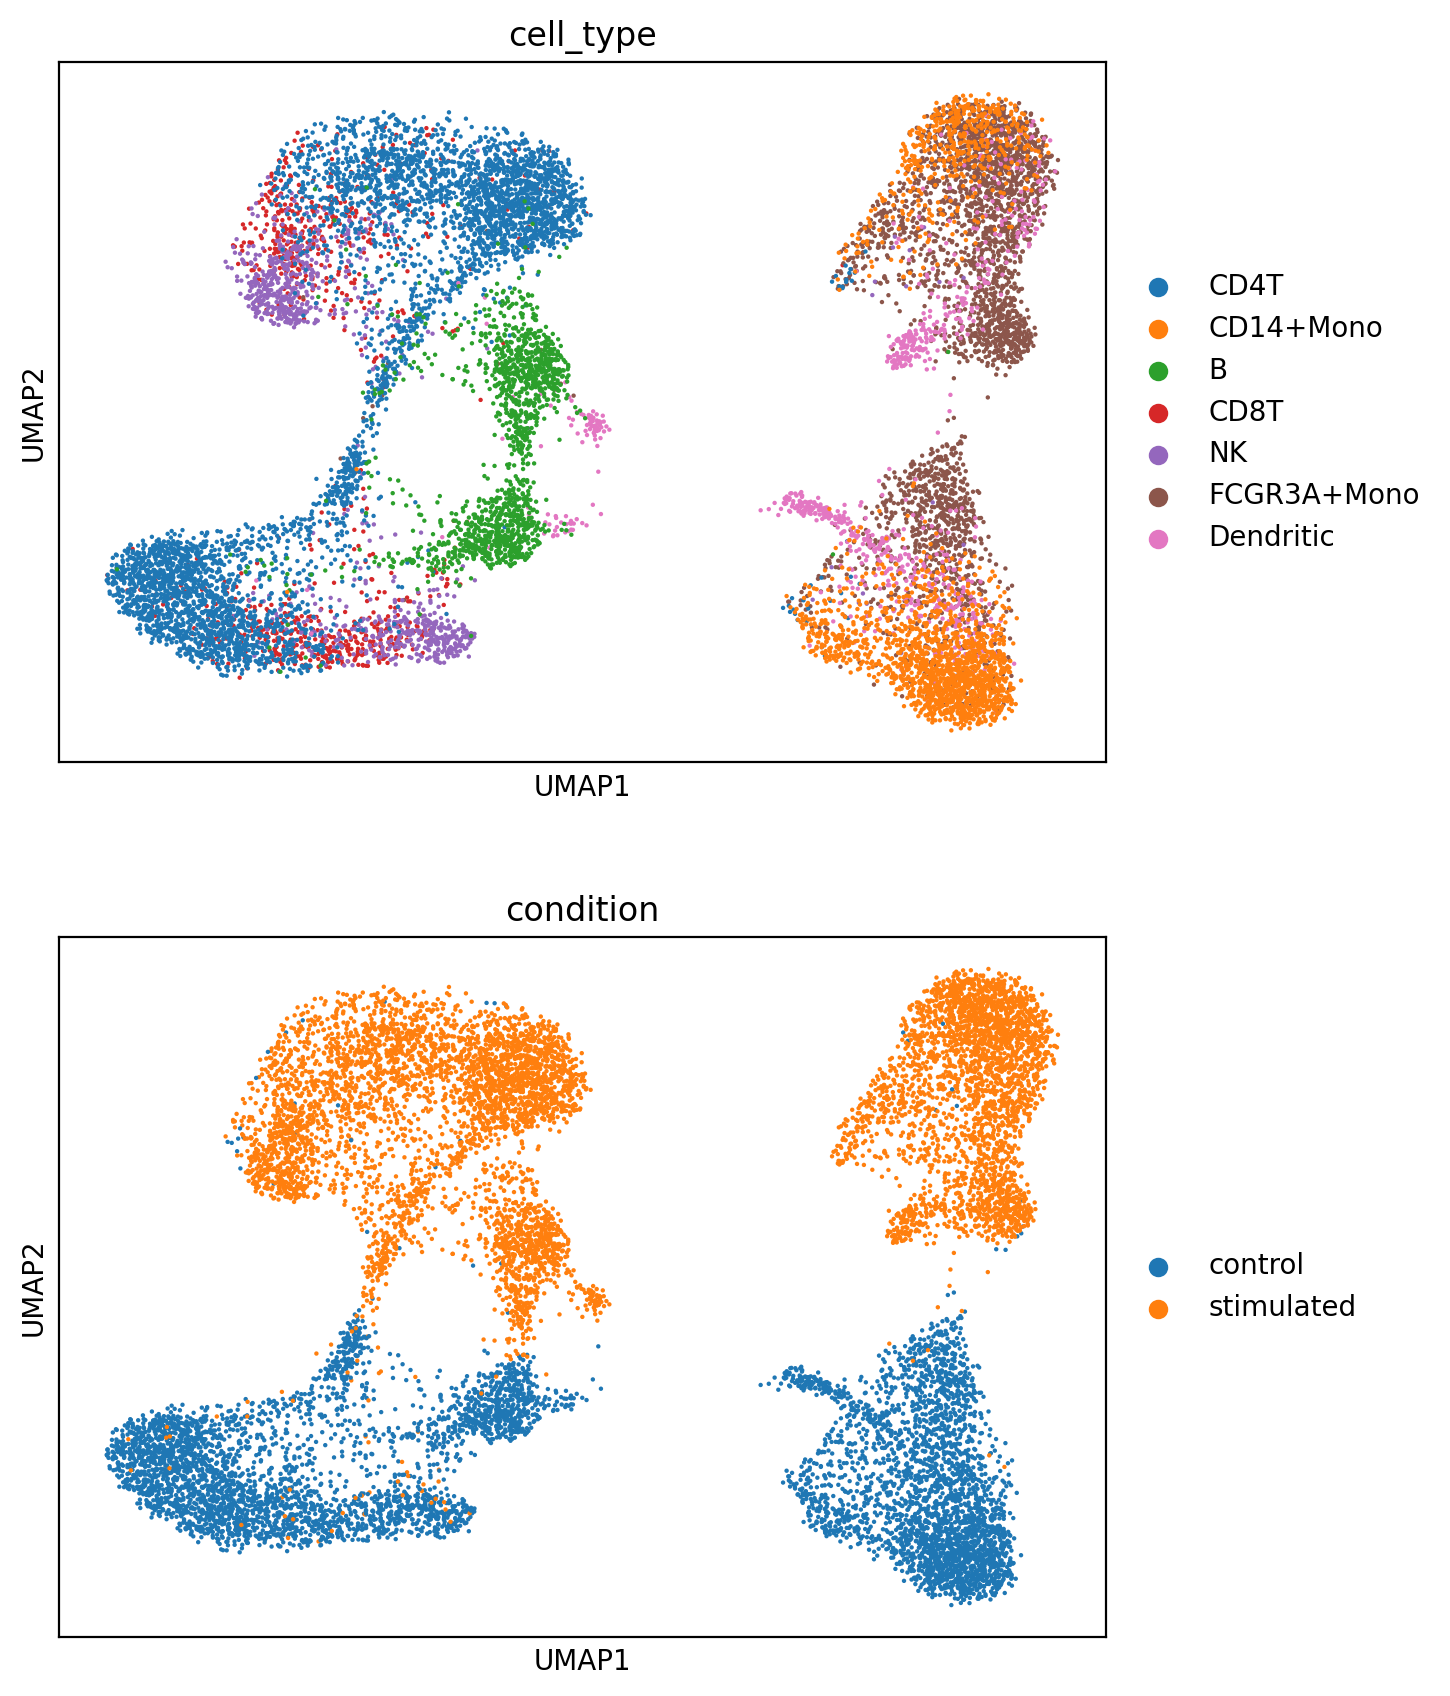

In [ ]:
sc.pp.neighbors(PBMC_train, use_rep='latent_embedding', n_neighbors=15) # use_rep specifies that the calculation is based on the latent embedding
sc.tl.umap(PBMC_train, random_state=1) #set random state to ensure reproducibility
sc.pl.umap(PBMC_train, color=["cell_type", "condition"], size=10, ncols = 1)

We can see a clear separation into cell types and conditions. However, the latent variables are **not directly interpretable**, i.e. we don't know the biological importance of these features.<br>

> Repeat this analysis with a smaller latent space (reduce the number of `latent_dims`) → Can you see an effect? If so, can you explain it?

> How does the proportions of the MSE and KLD in the loss function affect the cell's embedding in the latent space? To assess this, try larger values for `beta`. Can you explain the observed changes in the latent embedding?

## Biologically Interpretable VAEs
To achieve a **direct interpretability** of the model's features, we can modify the architecture of the VAE. Our aim is, that every latent variable represents a **biological pathway**. We follow the same principle that is applied in **VEGA** ([Seninge *et al* (2021)](https://www.nature.com/articles/s41467-021-26017-0)).<br>

We want to provide the interpretability through the model's **decoder**, and therefore apply the following modifications:

1. **one-layer** decoder: every latent variable is directly connected to the output variables.
2. **linear** decoder: we do not use any activation function (sigmoid, ReLU,...) in the decoder.
3. **positive** decoder: we restrict the decoder weights to positive values by setting all negative weights to zero. This allows direct interpretability of the activities of the latent variables.
4. **sparse** decoder: we use prior-defined gene modules to define the decoder connections. Every latent variable is associated with a specific biological term (pathway) and is only connected to output genes that are related to this pathway.

We first need to provide the gene modules that define the model's decoder connections. We use a .gmt file that contains genesets of pathways.

In [ ]:
# download the .gmt file

!wget -O reactomes.gmt https://raw.githubusercontent.com/LucasESBS/vega-reproducibility/main/data/reactomes.gmt

--2024-03-28 12:43:33--  https://raw.githubusercontent.com/LucasESBS/vega-reproducibility/main/data/reactomes.gmt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330737 (323K) [text/plain]
Saving to: ‘reactomes.gmt’

reactomes.gmt       100%[===================>] 322.99K  --.-KB/s    in 0.03s   

2024-03-28 12:43:34 (9.85 MB/s) - ‘reactomes.gmt’ saved [330737/330737]



Lets first have a look at this file: <br>
The first column specifies the gene modulating variable (GMV), in this case the pathway. The second column includes information of the data base, and the following columns contain the genes of the geneset:

In [ ]:
with open('reactomes.gmt') as gmt_file: #print first lines of the gmt file
    gmt_head = gmt_file.readlines()[0:10]
    for row in gmt_head:
      print(row)

REACTOME_GLYCOGEN_BREAKDOWN_GLYCOGENOLYSIS	http://www.broadinstitute.org/gsea/msigdb/cards/REACTOME_GLYCOGEN_BREAKDOWN_GLYCOGENOLYSIS	AGL	GYG1	PGM1	PHKA1	PHKA2	PHKB	PHKG1	PHKG2	PGM2	PYGB	PYGL	PYGM	PHKA1P1	LOC650556	CALM1	CALM2	CALM3	GYG2

REACTOME_TRANSLATION	http://www.broadinstitute.org/gsea/msigdb/cards/REACTOME_TRANSLATION	SEC61B	RPL35	EEF1DP1	RPL7AP27	DDOST	EEF1A1	EEF1B2	EEF1D	EEF1G	EEF2	EIF1AX	EIF2S1	EIF2B1	EIF2S3	EIF4A1	EIF4A2	EIF4B	EIF4E	EIF4EBP1	EIF4G1	EIF5	ETF1	FAU	TRAM1	SEC11A	SEC61G	RPL13A	GSPT2	RPL36	PABPC1	EIF3K	RPL10P16	FAM153A	SPCS1	SEC61A1	EIF3FP3	RPL36P14	EIF3E	RPSAP12	RPS8P10	RPL7AP66	RPL10P9	RPS12P4	RPSA	RPS26P10	RPL23AP2	RPS12P22	RPL21P29	RPS26P35	RPL10A	RPL26L1	SEC61A2	SRPRB	SPCS3	RPL3	RPL3L	RPL4	RPL5	RPL6	RPL7	RPL7A	RPL8	RPL9	RPL10	RPL11	RPL12	RPL13	RPL15	RPL17	RPL18	RPL18A	RPL19	RPL21	RPL22	RPL23A	RPL24	RPL26	RPL27	RPL30	RPL27A	RPL28	RPL29	RPL31	RPL32	RPL34	RPL35A	RPL37	RPL37A	RPL38	RPL39	RPL41	RPL36A	RPLP0	RPLP1	RPLP2	RPN1	RPN2	RPS2	RPS3	RPS3A	RPS4X	RPS4Y1	RPS5

Based on this .gmt file, we first write a function to create a **mask $M$**, that we will use later to define the decoder connections. <br>

The rows of the mask $M$ correspond to genes (of the data set), the columns to pathways (of the .gmt file). If the gene $i$ is annotated in the gene set of the pathway $j$, the corresponding entry of the matrix $M(i,j)$ contains the value 1, otherwise the value 0. <br>

We can further add **fully connected nodes** to the latent space (with the parameter `add_nodes`), that are connected to all output variables. This allows better data reconstruction and compensates for connections, that are missing in our prior defined gene sets (these are likely incomplete). These fully connected nodes are also included in the mask (all values are ones).

In [ ]:
####### In the following sections, we used and adapted code from https://github.com/LucasESBS/vega ######

def create_mask(adata, gmt_path:str=None, add_nodes:int=1, sep = "\t"):
    """
    Initialize mask M for GMVs from a .gmt file
    Args:
        adata (Anndata): Scanpy single-cell object, we will store the computed mask and the names of the biological processes there
        gmt_path (str): path to .gmt file
        add_nodes (int): Additional latent nodes for capturing additional variance
    Return:
        adata (Anndata): Scanpy single-cell object that now stores the computed mask and the names of biological processes (in the .uns["_vega"] attribute)
        mask (array): mask M that specifies whether a gene is included in the gene set of a pathway (value one) or not (value zero)
    """

    gmv_dict = OrderedDict()
    with open(gmt_path) as f:
        for line in f.readlines():
            line = line.strip()
            spli = line.split(sep)
            gmv_dict[spli[0]] = spli[2:]

    feature_list = adata.var.index.tolist()


    # Create mask
    mask = np.zeros((len(feature_list), len(gmv_dict)))
    for j, k in enumerate(gmv_dict.keys()):
        for i in range(mask.shape[0]):
            if feature_list[i] in gmv_dict[k]:
                mask[i,j] = 1.
    # Add unannotated nodes
    vec = np.ones((mask.shape[0], add_nodes))
    mask = np.hstack((mask, vec))

    adata.uns['_vega'] = dict() #create attribute "_vega" to store the mask and pathway information
    adata.uns['_vega']['mask'] = mask
    adata.uns['_vega']['gmv_names'] = list(gmv_dict.keys()) + ['UNANNOTATED_'+str(k) for k in range(add_nodes)]

    return adata, mask

In [ ]:
# we can now create the mask from the .gmt file and our data set
PBMC_train, mask = create_mask(PBMC_train, gmt_path= "reactomes.gmt", add_nodes=1)

In [ ]:
# Let's take a look at the mask:
print(mask)
# we can see that the mask stores zeroes and ones
# the last column contains only ones, since this column represents the fully connected node (connected to all output genes)

[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


Since we want to achieve the interpretability through the model's **decoder**, we can just modify this part of the architecture while using the same encoder as before:

In [ ]:
# define VEGA's decoder

class DecoderVEGA(nn.Module):
  """
  Define VEGA's decoder (sparse, one-layer, linear, positive)
  """
  def __init__(self,
               mask):
        super(DecoderVEGA, self).__init__()

        self.sparse_layer = nn.Sequential(SparseLayer(mask)) # we define the architecture of the decoder below with the class "SparseLayer"

  def forward(self, x):
    z = self.sparse_layer(x.to(device))
    return(z)

  def positive_weights(self):
      """
      constrain the decoder to positive weights (set negative weigths to zero)
      """
      w = self.sparse_layer[0].weight
      w.data = w.data.clamp(0)
      return w


# define a class SparseLayer, that specifies the decoder architecture (sparse connections based on the mask)
class SparseLayer(nn.Module):
  def __init__(self, mask):
        """
        Extended torch.nn module which mask connection
        """
        super(SparseLayer, self).__init__()

        self.mask = nn.Parameter(torch.tensor(mask, dtype=torch.float).t(), requires_grad=False)
        self.weight = nn.Parameter(torch.Tensor(mask.shape[1], mask.shape[0]))
        self.bias = nn.Parameter(torch.Tensor(mask.shape[1]))
        self.reset_parameters()

        # mask weight
        self.weight.data = self.weight.data * self.mask

  def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

  def forward(self, input):
        # See the autograd section for explanation of what happens here
        return SparseLayerFunction.apply(input, self.weight, self.bias, self.mask)


######### You don't need to understand this part of the code in detail #########
class SparseLayerFunction(torch.autograd.Function):
    """
    We define our own autograd function which masks it's weights by 'mask'.
    For more details, see https://pytorch.org/docs/stable/notes/extending.html
    """

    # Note that both forward and backward are @staticmethods
    @staticmethod
    def forward(ctx, input, weight, bias, mask):

        weight = weight * mask # change weight to 0 where mask == 0
        #calculate the output
        output = input.mm(weight.t())
        output += bias.unsqueeze(0).expand_as(output) # Add bias to all values in output
        ctx.save_for_backward(input, weight, bias, mask)
        return output

    @staticmethod
    def backward(ctx, grad_output): # define the gradient formula
        input, weight, bias, mask = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = grad_mask = None

        # These needs_input_grad checks are optional and only to improve efficiency
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.t().mm(input)
            # change grad_weight to 0 where mask == 0
            grad_weight = grad_weight * mask
        if ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0).squeeze(0)

        return grad_input, grad_weight, grad_bias, grad_mask


In [ ]:
class VEGA(nn.Module):
    def __init__(self, latent_dims, input_dims, mask, dropout = 0.3, z_dropout = 0.3):
        super(VEGA, self).__init__()
        self.encoder = Encoder(latent_dims, input_dims, dropout, z_dropout) # we use the same encoder as before (two-layer, fully connected, non-linear)
        self.decoder = DecoderVEGA(mask)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
#training loop
def trainVEGA(vae, data, epochs=100, beta = 0.0001, learning_rate = 0.001):
    opt = torch.optim.Adam(vae.parameters(), lr = learning_rate, weight_decay = 5e-4)
    vae.train() #train mode
    losses = []
    klds = []
    mses = []

    for epoch in range(epochs):
        loss_e = 0
        kld_e = 0
        mse_e = 0

        for x in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = vae(x)
            mse = ((x - x_hat)**2).sum()
            kld = beta* vae.encoder.kl
            loss = mse +  kld # loss calculation
            loss.backward()
            opt.step()
            loss_e += loss.to('cpu').detach().numpy()
            kld_e += kld.to('cpu').detach().numpy()
            mse_e += mse.to('cpu').detach().numpy()
            vae.decoder.positive_weights() # we restrict the decoder for positive weights

        losses.append(loss_e/(len(data)*128))
        klds.append(kld_e/(len(data)*128))
        mses.append(mse_e/(len(data)*128))

        print("epoch: ", epoch, " loss: ", loss_e/(len(data)*128))

    return vae, losses, klds, mses

We initialize the VEGA model, based on the mask that we constructed above:

In [ ]:
vega = VEGA(latent_dims= mask.shape[1], input_dims = mask.shape[0], mask = mask.T, z_dropout = 0.5, dropout = 0.3).to(device)
# model training
vega, vega_losses, vega_klds, vega_mses = trainVEGA(vega, PBMC_trainX,epochs = 100, beta = 0.0001) #takes about 2 mins on GPU

epoch:  0  loss:  340.5863746787017
epoch:  1  loss:  309.39660126308223
epoch:  2  loss:  296.94265948601486
epoch:  3  loss:  285.03912382305793
epoch:  4  loss:  277.34535246075325
epoch:  5  loss:  270.0902613513875
epoch:  6  loss:  264.2828821146263
epoch:  7  loss:  259.6643161413805
epoch:  8  loss:  254.80099156217756
epoch:  9  loss:  250.54355434201798
epoch:  10  loss:  246.79649007545328
epoch:  11  loss:  243.5580506234799
epoch:  12  loss:  240.12999840502468
epoch:  13  loss:  236.9556444276054
epoch:  14  loss:  234.26188530112213
epoch:  15  loss:  232.0707636419332
epoch:  16  loss:  229.24071373129792
epoch:  17  loss:  227.13787985747715
epoch:  18  loss:  224.1689058699698
epoch:  19  loss:  221.9946587040739
epoch:  20  loss:  220.0604763390883
epoch:  21  loss:  217.88739870179376
epoch:  22  loss:  215.8685381187583
epoch:  23  loss:  214.59035110473633
epoch:  24  loss:  213.3572571952388
epoch:  25  loss:  211.6262318593151
epoch:  26  loss:  210.753276896926

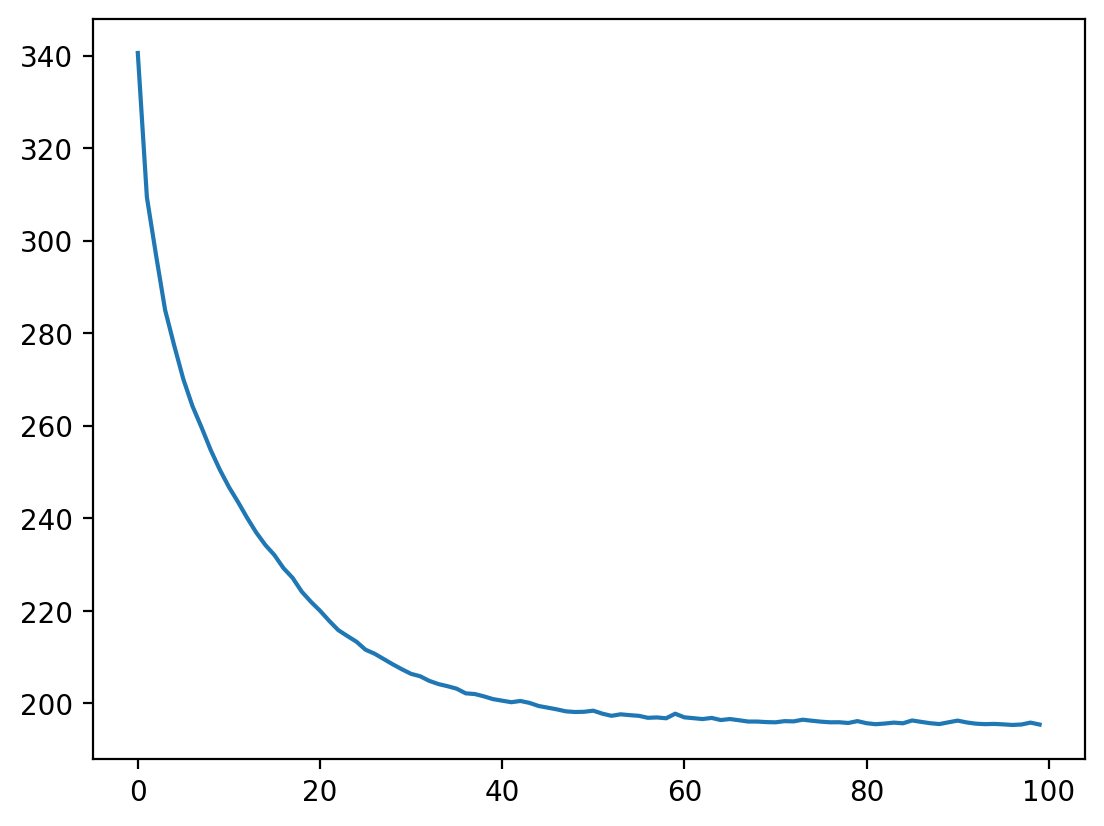

In [ ]:
# plot the loss curve
plt.plot(vega_losses)

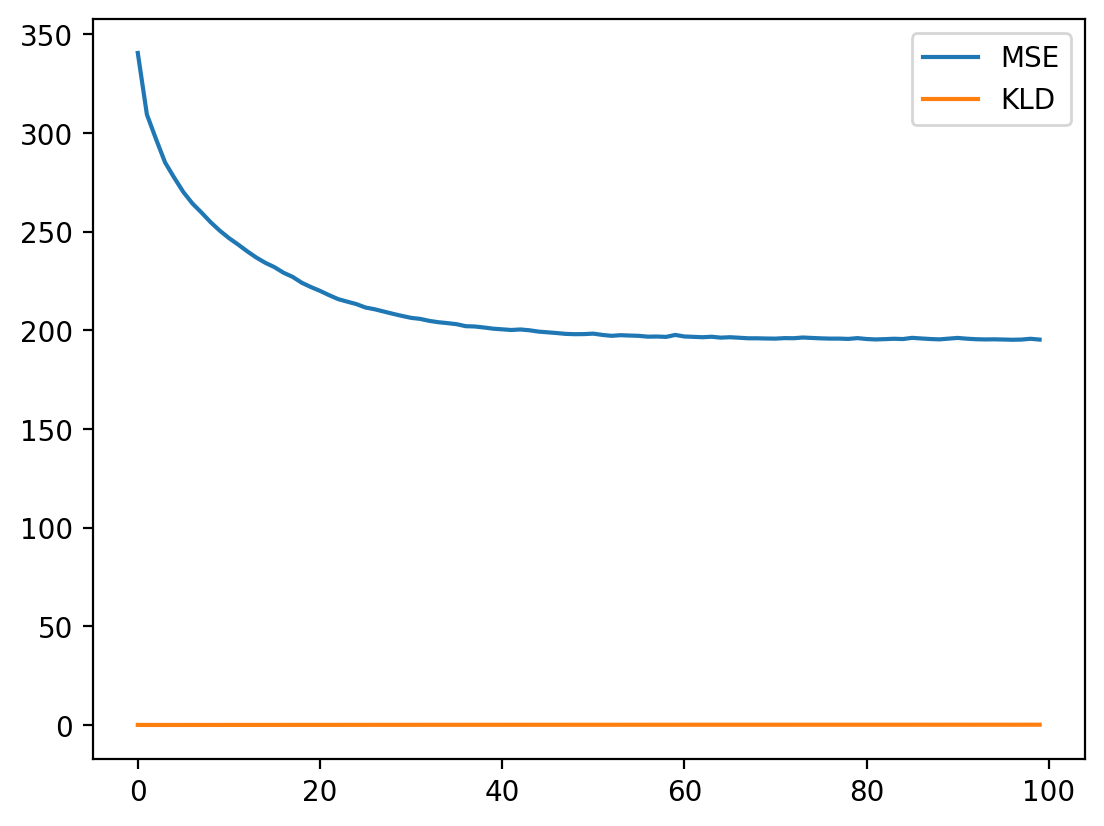

In [ ]:
# plot mse and kld
plt.plot(vega_mses, label = "MSE")
plt.plot(vega_klds, label = "KLD")
plt.legend()

In [ ]:
# we can see that all decoder weights are positive:
print(torch.sum(vega.state_dict()["decoder.sparse_layer.0.weight"]<0)) # zero negative weights

tensor(0, device='cuda:0')


Again, we can have a look at the embedding of the cells in the latent space, colored by condition and cell type:


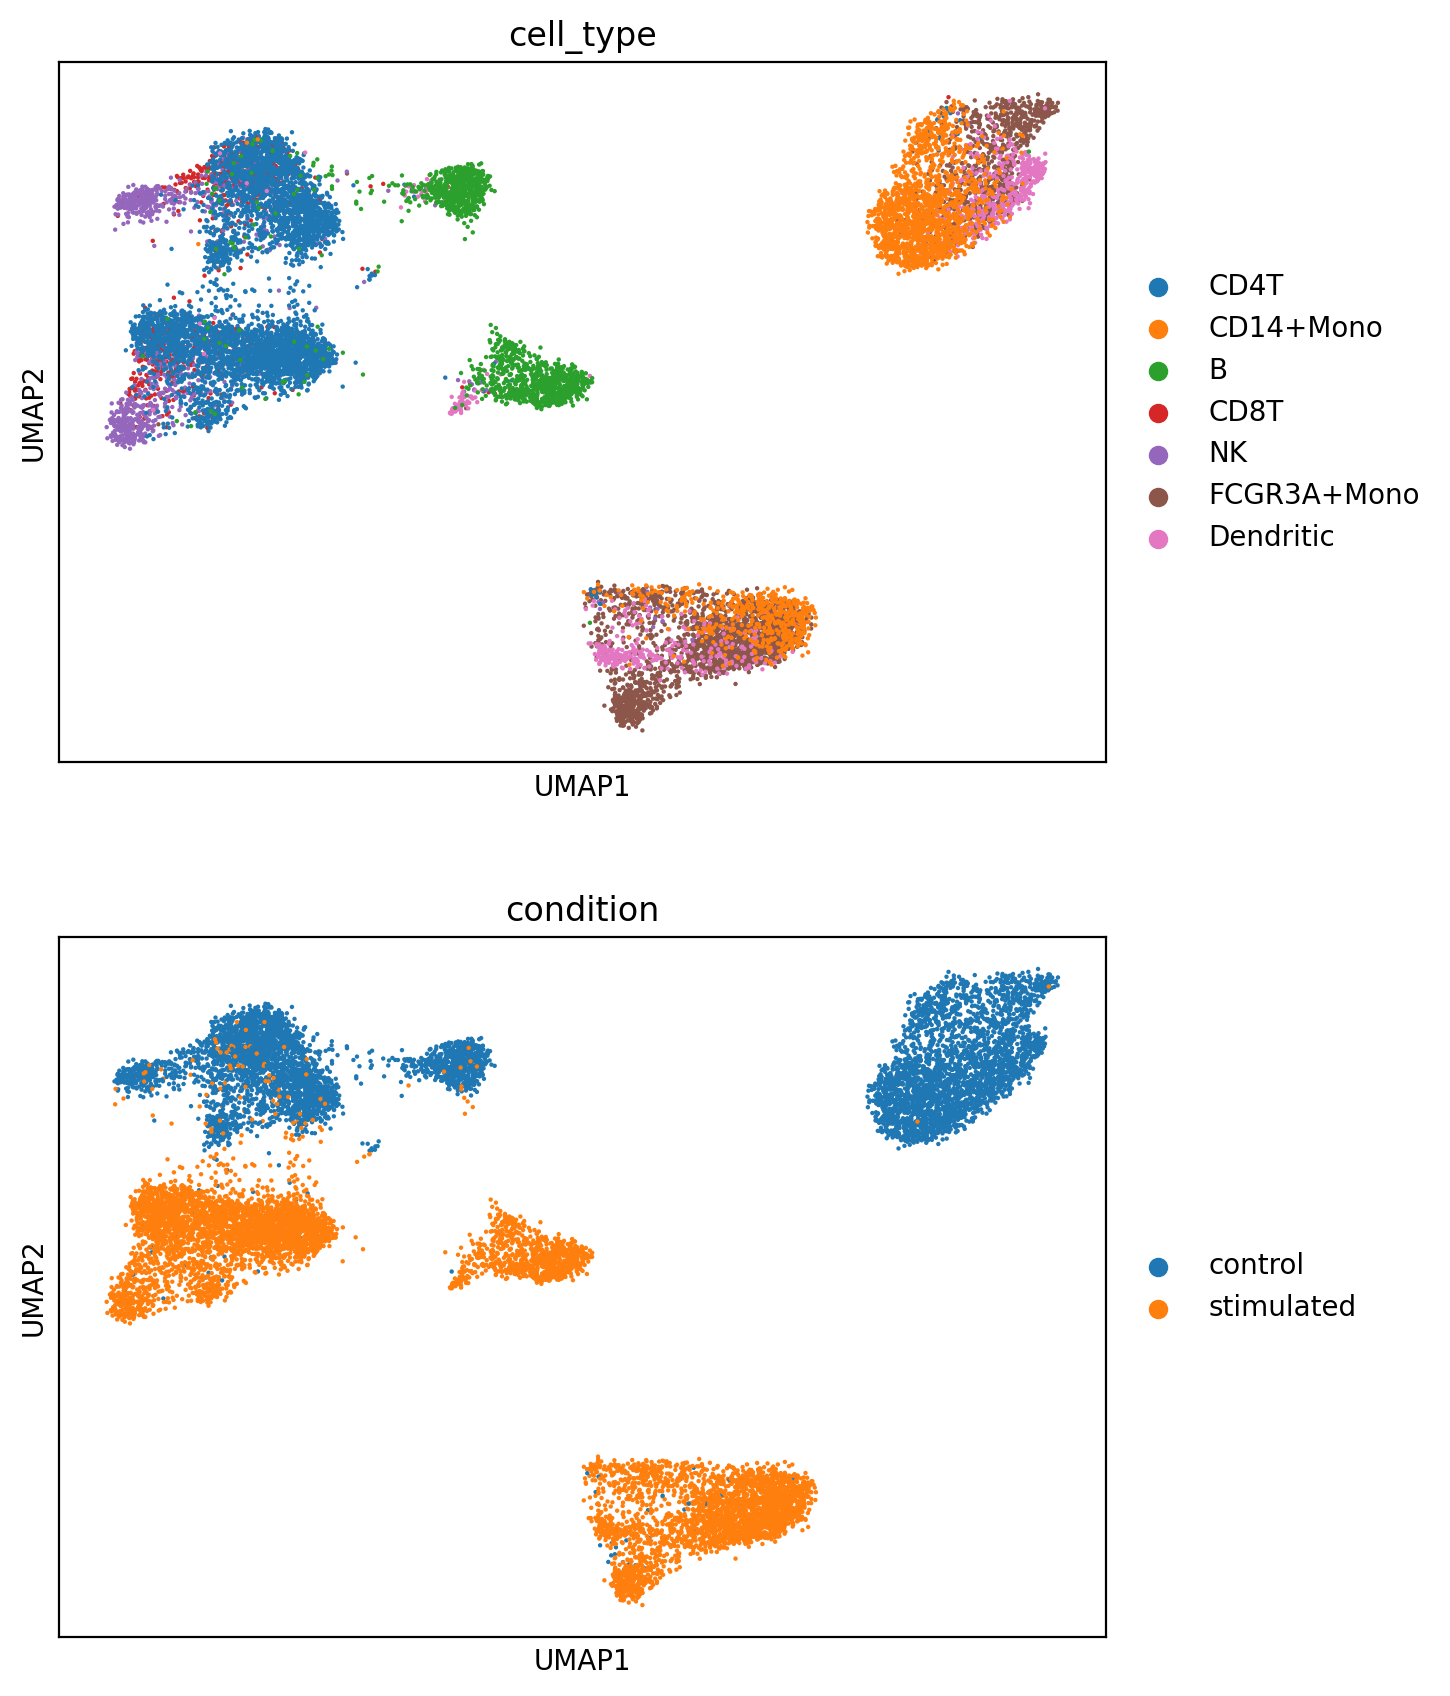

In [ ]:
PBMC_train.obsm["latent_embedding"] = to_latent(vega, PBMC_train) # project the cells to the model's latent space

# UMAP based on the latent embedding
sc.pp.neighbors(PBMC_train, use_rep='latent_embedding', n_neighbors=15)
sc.tl.umap(PBMC_train, random_state=1) #set random state to ensure reproducibility
sc.pl.umap(PBMC_train, color=["cell_type", "condition"], size=10, ncols = 1)

Since the latent variables now each correspond to a specific pathway, we can further color the cells according to pathway activities:

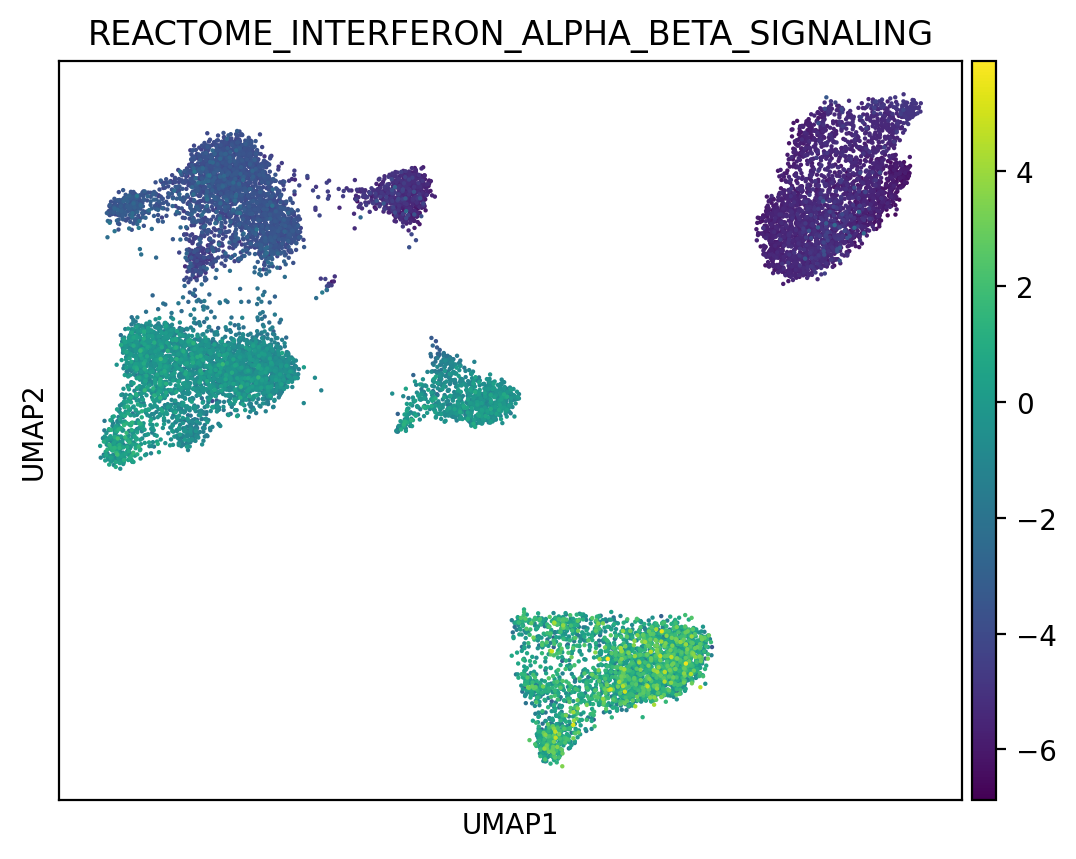

In [ ]:
pathway_of_interest = "REACTOME_INTERFERON_ALPHA_BETA_SIGNALING"

pathways = PBMC_train.uns["_vega"]["gmv_names"] # the names of the GMVs are stored here
pw_activities = PBMC_train.obsm["latent_embedding"] # pathway activities (we stored them here when projecting the data to the latent space (see above))

#for visualization with the scanpy package, we need to provide the annotation (based on which cells should be colored) in the .obs attribute
PBMC_train.obs[pathway_of_interest] =  PBMC_train.obsm["latent_embedding"][:,pathways.index(pathway_of_interest)]
sc.pl.umap(PBMC_train, color=[pathway_of_interest], size=10, ncols = 1)


As expected, the `"REACTOME_INTERFERON_ALPHA_BETA_SIGNALING"` pathway is more active in IFNb stimulated cells!

> Color the cells according to `'REACTOME_ANTIVIRAL_MECHANISM_BY_IFN_STIMULATED_GENES'`, `'REACTOME_DOPAMINE_NEUROTRANSMITTER_RELEASE_CYCLE'` and `'REACTOME_DOWNSTREAM_SIGNALING_EVENTS_OF_B_CELL_RECEPTOR_BCR'`. Can you observe the expected results? If not, what could be the reason for this?

We can further determine important genes for specific pathways by looking at the **decoder weights**. <br>
We therefore define a function to plot the ranked weights:

In [ ]:
def plot_ranked_gene_weights(model: VEGA, adata,
                        gmv,
                        n_genes: int = 10):
    """
    Plot gene members of input GMVs according to their magnitude.
    """
    w = vega.state_dict()["decoder.sparse_layer.0.weight"].to("cpu")
    gmv_names = list(adata.uns['_vega']['gmv_names'])
    gene_names = adata.var.index.tolist()


    # Get values
    i = gmv_names.index(gmv)
    w_i = w[:,i].detach().numpy()
    sort_idx = np.argsort(w_i)[::-1]
    sort_w = w_i[sort_idx][:n_genes]
    genes = np.array(gene_names)[sort_idx][:n_genes]

    # Set plot params
    ymin = np.min(sort_w)
    ymax = np.max(sort_w)
    ymax += 0.3*(ymax - ymin)

    # Plot
    for ig, gene_name in enumerate(genes):
        plt.text(
            ig,
            sort_w[ig],
            gene_name,
            rotation='vertical',
            verticalalignment='bottom',
            horizontalalignment='center',
            color="black"
        )
    plt.title(gmv)
    plt.ylim(ymin, ymax)
    plt.xlim(-0.9, n_genes - 0.1)
    plt.xlabel('Ranking')
    plt.ylabel('Weight magnitude')
    plt.xticks(np.arange(0, n_genes, step=1), labels = np.arange(1, n_genes+1, step=1))

    plt.show()

For instance, we can identify ISGs (Interferon stimulated genes) and IFITs (Interferon Induced Proteins With Tetratricopeptide Repeat) for the Interferon alpha/beta signaling pathway:

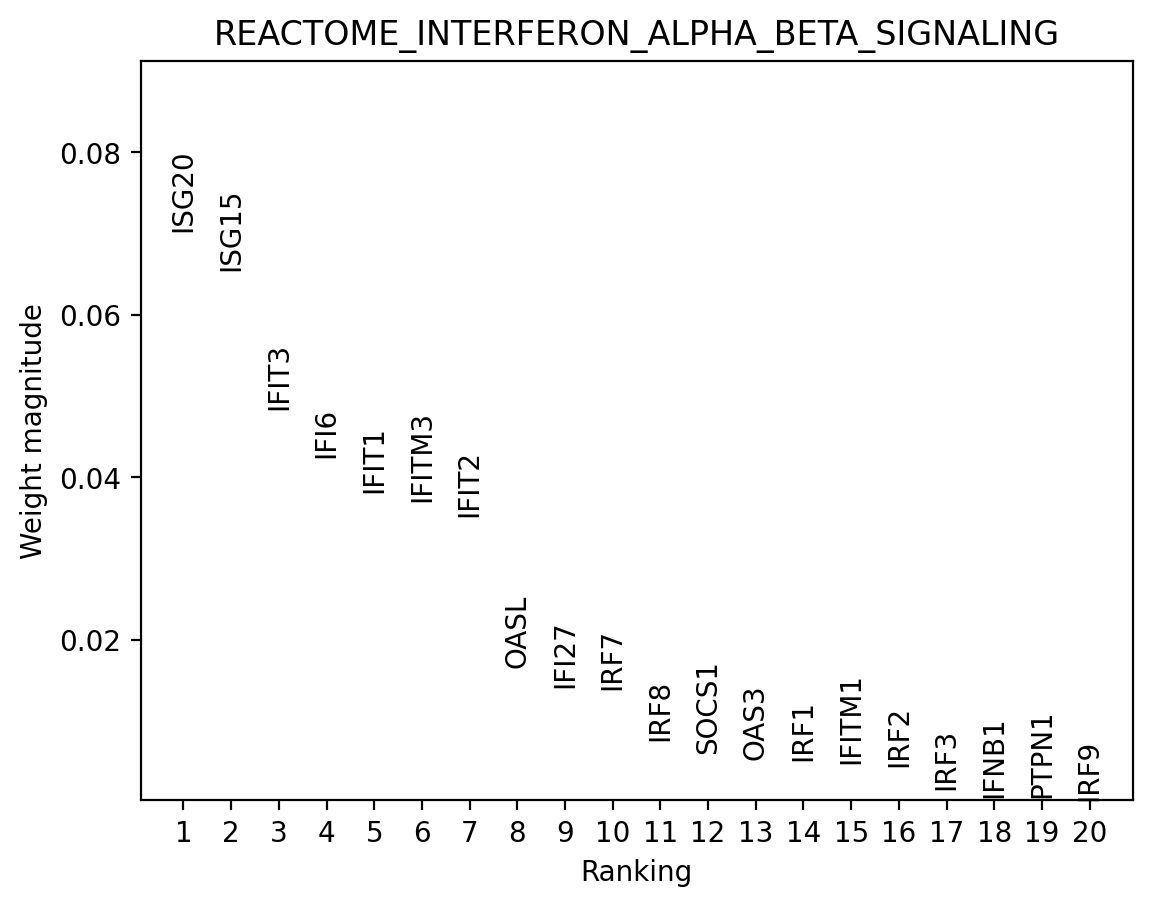

In [ ]:
plot_ranked_gene_weights(vega, gmv= "REACTOME_INTERFERON_ALPHA_BETA_SIGNALING", adata = PBMC_train, n_genes = 20)

## Exercises
1. Adding fully connected nodes improves the data reconstruction and can compensate for missing links in our prior defined gene modules. However, what potential drawbacks might arise from adding too many of these nodes?

2. As you have seen above, we added a dropout layer in the model's latent space. What could be the advantage of this?

3. We provide a set of validation data below (`PBMC_valid`). <br>
Can you add this validation data to the training loop, and check whether our model is **overfitted**? For this, plot both loss curves (training and validation), and explain how we could identify potential overfitting based on these curves.<br>
Can you explain why the loss of the validation set is smaller than the loss of the training set?
<br> *Hint:* First, you need to set up the data set in the right format with the `torch.utils.data.DataLoader()` function. Then, iterate over this data within the training loop. Make sure to set the model to evaluation mode (with `vae.eval()`) and to not update the parameters, since this is only for validation!

In [ ]:
# download the data
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1rJKZYIG7rv7BQbDD9RElYOgHcxxzjcYj' -O PBMC_valid.h5ad
# load data as anndata object
PBMC_valid = sc.read_h5ad( "PBMC_valid.h5ad")

--2024-03-28 12:45:45--  https://docs.google.com/uc?export=download&id=1rJKZYIG7rv7BQbDD9RElYOgHcxxzjcYj
Resolving docs.google.com (docs.google.com)... 142.251.180.102, 142.251.180.101, 142.251.180.113, ...
Connecting to docs.google.com (docs.google.com)|142.251.180.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1rJKZYIG7rv7BQbDD9RElYOgHcxxzjcYj&export=download [following]
--2024-03-28 12:45:45--  https://drive.usercontent.google.com/download?id=1rJKZYIG7rv7BQbDD9RElYOgHcxxzjcYj&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.112.132, 2607:f8b0:4001:c12::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.112.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10923368 (10M) [application/octet-stream]
Saving to: ‘PBMC_valid.h5ad’

PBMC_valid.h5ad     100%[===================>]  10.42M  40.9MB

In [ ]:
###### provide your solution for exercise 3 here ######

### Here you should set up the data
PBMC_validX =

### training loop
def trainVEGA_with_valid(vae, data, val_data, epochs=100, beta = 0.0001, learning_rate = 0.001):
    opt = torch.optim.Adam(vae.parameters(), lr = learning_rate, weight_decay = 5e-4)
    train_losses = []
    valid_losses = []
    for epoch in range(epochs):
        train_loss_e = 0
        valid_loss_e = 0
        vae.train() #train mode

        for x in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + beta* vae.encoder.kl
            loss.backward()
            opt.step()
            train_loss_e += loss.to('cpu').detach().numpy()
            vae.decoder.positive_weights() # we restrict the decoder to positive weights
        train_losses.append(train_loss_e/(len(data)*128))

        #### Here you should add the validation loop

        print("epoch: ", epoch, " train_loss: ", train_loss_e/(len(data)*128))
        #### print also the validation loss after each epoch!

    return vae, train_losses, valid_losses


# model initialization and training
vega = VEGA(latent_dims= mask.shape[1], input_dims = mask.shape[0], mask = mask.T, dropout = 0.3, z_dropout = 0.3).to(device)
vega, train_losses, valid_losses = trainVEGA_with_valid(vega, PBMC_trainX, PBMC_validX, epochs = 50, beta = 0.0001)


### plot the loss curves:
